# Web Scraping Job Vacancies Part 2


At the moment, I am extending the dataset from my previous web scraping project. In this phase, I intend to include major cities in Indonesia to observe the current trends and combine them into a single dataset. I generated a list of large cities programmatically to see the results. Most of the code used below is based on my earlier project, with the main addition being the inclusion of multiple cities to further analyze the effect.

## Step 1: Data Collection and Preparation


In [ ]:
# Data handling and cleaning
import pandas as pd
import numpy as np

# Visualization libraries (commonly used for EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Web scraping essentials
import requests
from bs4 import BeautifulSoup

In [ ]:
base_url = "https://id.jobstreet.com/id/{keyword}-jobs/in-{location}?page={page}"

jobs = []

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/114.0.0.0 Safari/537.36"
}

In [ ]:
# List of big cities in Indonesia with latitude & longitude
indonesia_cities = [
    {"city": "Jakarta", "latitude": -6.2088, "longitude": 106.8456},
    {"city": "Surabaya", "latitude": -7.2575, "longitude": 112.7521},
    {"city": "Bandung", "latitude": -6.9175, "longitude": 107.6191},
    {"city": "Medan", "latitude": 3.5952, "longitude": 98.6722},
    {"city": "Semarang", "latitude": -6.9667, "longitude": 110.4167},
    {"city": "Palembang", "latitude": -2.9761, "longitude": 104.7754},
    {"city": "Makassar", "latitude": -5.1477, "longitude": 119.4327},
    {"city": "Tangerang", "latitude": -6.1783, "longitude": 106.6319},
    {"city": "Depok", "latitude": -6.4025, "longitude": 106.7942},
    {"city": "Bekasi", "latitude": -6.2349, "longitude": 106.9896},
    {"city": "Bogor", "latitude": -6.5971, "longitude": 106.8060},
    {"city": "Malang", "latitude": -7.9839, "longitude": 112.6214},
    {"city": "Denpasar", "latitude": -8.6705, "longitude": 115.2126},
    {"city": "Batam", "latitude": 1.0456, "longitude": 104.0305},
    {"city": "Pekanbaru", "latitude": 0.5071, "longitude": 101.4478},
    {"city": "Padang", "latitude": -0.9471, "longitude": 100.4172},
    {"city": "Banjarmasin", "latitude": -3.3167, "longitude": 114.5908},
    {"city": "Pontianak", "latitude": -0.0263, "longitude": 109.3425},
    {"city": "Manado", "latitude": 1.4748, "longitude": 124.8421},
    {"city": "Yogyakarta", "latitude": -7.7956, "longitude": 110.3695}
]


In [ ]:
def create_df_job ( keyword, location, max_page, data):
  MAX_PAGES = max_page #number of page to scan
  base_url = "https://id.jobstreet.com/id/{keyword}-jobs/in-{location}?page={page}"

  for page in range(1, MAX_PAGES + 1):
    url = base_url.format(keyword=keyword, location=location, page=page)
    print("Fetching:", url)

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print("Error:", response.status_code)
        break

    soup = BeautifulSoup(response.text, "html.parser")
    jobs = soup.find_all("article")

    if not jobs:
        print("No more jobs found, stopping.")
        break

    print(f"Page {page}: {len(jobs)} jobs found")

    for job in jobs:
        title = job.find("a", {"data-automation": "jobTitle"})
        classification = job.find("span", {"data-automation": "jobClassification"})
        company = job.find("a", {"data-automation": "jobCompany"})
        job_location = job.find("a", {"data-automation": "jobLocation"})
        postings = job.find("span", {"data-automation": "jobListingDate"})
        salary = job.find("span", {"data-automation": "jobSalary"})
        job_description = job.find("span", {"data-automation": "jobShortDescription"})

        # print(f"Title: {title.get_text(strip=True) if title else None}")
        # print(f"Company: {company.get_text(strip=True) if company else None}")
        # print(f"Location: {job_location.get_text(strip=True) if job_location else None}")
        # print(f"Posting: {postings.get_text(strip=True) if postings else None}")
        # print(f"Salary: {salary.get_text(strip=True) if salary else None}")
        # print("-" * 40)

        data.append({
              "Title": title.get_text(strip=True) if title else None,
              "Classification": classification.get_text(strip=True) if classification else None,
              "Company": company.get_text(strip=True) if company else None,
              "Location": job_location.get_text(strip=True) if job_location else None,
              "Posting": postings.get_text(strip=True) if postings else None,
              "Salary": salary.get_text(strip=True) if salary else None,
              "Description": job_description.get_text(strip=True) if job_description else None
          })
  return data


In [ ]:
import re

def normalize_number(s: str) -> float:
    """
    Convert salary string with commas/dots to float safely.
    Handles '1.000.000,10' and '1,000,000.10'.
    """
    # print(s)
    if s is None:
      return None
    if not re.search(r"\d", s):
      return None

    s = s.strip()

    # Case 1: European/Indonesian format → decimals with comma
    if re.search(r",\d{1,2}$", s):
        s = s.replace(".", "")       # remove thousands separator
        s = s.replace(",", ".")      # convert decimal comma to dot

    # Case 2: US format → decimals with dot
    elif re.search(r"\.\d{1,2}$", s):
        s = s.replace(",", "")       # remove thousands separator

    # Case 3: No decimals → just strip separators
    else:
        s = s.replace(".", "").replace(",", "")

    return float(s)


In [ ]:

def parse_salary(s):


    if pd.isna(s):
        return None, None, None,None


    if "per month" in s:
        unit = "month"
    elif "per year" in s:
        unit = "year"
    elif "per hour" in s:
        unit = "hour"
    else:
        unit = None

    if "Rp" in s:
       currency = "IDR"
    elif "$" in s:
        currency = "USD"
        convert = True
    elif "SGD" in s:
        currency = "SGD"
        convert = True
    else:
        currency = None


    s_clean = (s.strip().replace("Rp", "").replace("-", "–").replace("per month", "")
    .replace("per year", "").replace("per hour", "").replace("$", "").replace("(SGD)", "")
    .replace("(USD)", "").replace("IDR", "").replace("RM", "").replace("(MYR)", "")
    )
    low = None
    high = None
    if " – " in s_clean:
      s_clean = s_clean.split(" – ")
      low = s_clean[0]
      high = s_clean[1]
    else:
      low =s_clean
      high = s_clean


    return low,high, unit, currency






In [ ]:
df_job = []
for city in indonesia_cities:
  df_job.extend(create_df_job("Any",city["city"], 80))

In [ ]:
pd.DataFrame(df_job).to_csv("df_job.csv", index=False)

In [ ]:
df_job = pd.read_csv("df_job.csv")
df_job.head()

In [ ]:
df_job[["Salary_Low","Salary_High", "Unit", "Currency"]] = df_job["Salary"].apply(lambda x: pd.Series(parse_salary(x)))
df_job.head()

In [ ]:
df_job["Salary_Low"] = df_job["Salary_Low"].apply(lambda x: normalize_number(x))
df_job["Salary_High"] = df_job["Salary_High"].apply(lambda x: normalize_number(x))

In [ ]:
df_job.shape

(11933, 11)

**Amaziingg !!!**

With the maximum pages set for each city, the scraper generated over 11,000 job listings, which is significantly more than the previous dataset of only 2,560 entries. However, some cities do not have 80 pages of job postings, so the process stops earlier (for example, Medan only has 5 pages).

Note: The results may vary depending on the keyword. Currently, I am using the keyword “any” combined with city locations to generate the data. Using different keywords could produce different outcomes. Also, since job postings change over time, the dataset shown above reflects only the current snapshot of available jobs.

In [ ]:
df_job.to_csv("jobstreet_jobs_with_cities.csv", index=False, encoding="utf-8")

print("✅ Job data saved to jobstreet_jobs.csv")

✅ Job data saved to jobstreet_jobs.csv


## Step 2:Exploratory Data Analysis

In [ ]:
file_path = 'https://raw.githubusercontent.com/Jasman123/Web_scraping_and_Job_Analyze/main/jobstreet_jobs_with_cities.csv'
df = pd.read_csv(file_path)
df.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency
0,"Customer Service (Jakarta), Operations, SeaBank",(Call Center & Layanan Konsumen),PT Bank Seabank Indonesia,Jakarta Selatan,1 hari yang lalu,NaN,Carry out services to customers such as delive...,NaN,NaN,NaN,NaN
1,Young Professionals Fast Track,"(Manufaktur, Transportasi & Logistik)",Deliveree (PT Angkut Teknologi Indonesia),Jakarta Selatan,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ...",6000000.0,9000000.0,month,IDR
2,Customer Service and Operation Specialist (Air...,"(Manufaktur, Transportasi & Logistik)",Easy Speed International Logistics Limited,Jakarta Selatan,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...,8000000.0,12000000.0,month,IDR
3,Logistic,"(Manufaktur, Transportasi & Logistik)",NaN,Jakarta Raya,23 jam yang lalu,NaN,"Responsible of logistic from receipt, storage...",NaN,NaN,NaN,NaN
4,Customer Service Specialist,(Call Center & Layanan Konsumen),TE Connectivity,Jakarta Raya,16 jam yang lalu,NaN,"Involves demand planning, order management, cu...",NaN,NaN,NaN,NaN


In [ ]:
print(f"Number of rows: {df.shape[0]}")
df = df.drop_duplicates()
print(f"Number of rows after removing duplicates: {df.shape[0]}")

Number of rows: 11933
Number of rows after removing duplicates: 5228


The code executes drop_duplicates and shows that a significant portion **(more than 50%)** of the dataset has duplicate entries.

Why does this happen?
One possibility is that some of the cities are very close to each other (for example, Jakarta–Depok, which are about 29 km apart), causing job board openings to be duplicated.

In [ ]:
df.dtypes

,0
Title,object
Classification,object
Company,object
Location,object
Posting,object
Salary,object
Description,object
Salary_Low,float64
Salary_High,float64
Unit,object


In [ ]:
df.describe()

,Salary_Low,Salary_High
count,7.890000e+02,7.890000e+02
mean,7.521840e+06,9.831156e+06
std,9.526425e+06,1.362238e+07
min,2.500000e+03,3.000000e+03
25%,4.500000e+06,5.500000e+06
50%,6.000000e+06,7.500000e+06
75%,8.000000e+06,1.000000e+07
max,2.000000e+08,3.000000e+08


In [ ]:
df.isnull().sum()

,0
Title,0
Classification,0
Company,116
Location,0
Posting,0
Salary,4437
Description,1
Salary_Low,4439
Salary_High,4439
Unit,4440


In [ ]:
no_salary = float(df["Salary"].isnull().sum()) / len(df) * 100
print(f"Missing salary values: {no_salary:.2f}%")

Missing salary values: 84.87%


In [ ]:
no_company = df["Company"].nunique()
print(f"numbers of company: {no_company}")

numbers of company: 2218


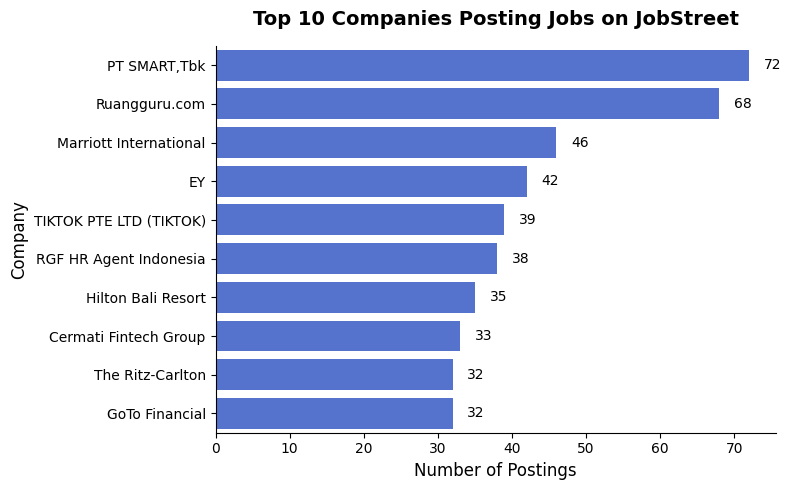

In [ ]:
# Top 10 companies with most job postings
df_top10_company = df["Company"].value_counts().head(10)

plt.figure(figsize=(8, 5))
sns.barplot(
    y=df_top10_company.index,
    x=df_top10_company.values,
    color="royalblue"
)

# Add value labels on bars
for i, val in enumerate(df_top10_company.values):
    plt.text(val + 2, i, str(val), va='center', fontsize=10)

# Labels and title
plt.ylabel("Company", fontsize=12)
plt.xlabel("Number of Postings", fontsize=12)
plt.title("Top 10 Companies Posting Jobs on JobStreet", fontsize=14, fontweight="bold", pad=15)

sns.despine()
plt.tight_layout()
plt.show()

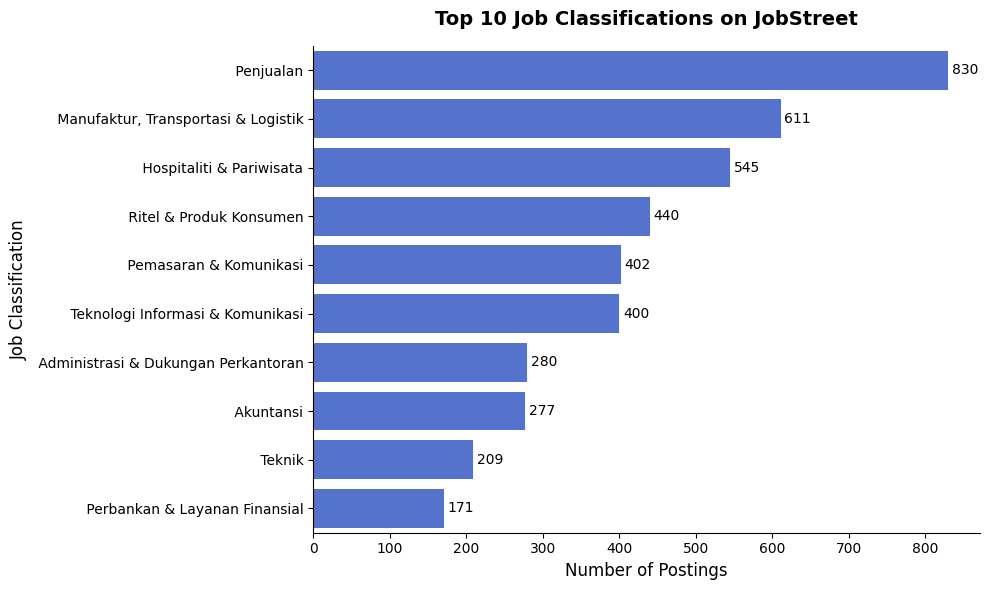

In [ ]:
df_top10job = df["Classification"].value_counts().head(10).reset_index()
df_top10job.columns = [ "Classification", "Sum of Postings"]
df_top10job['Classification'] = df_top10job['Classification'].str.replace(
    r"\((.*)\)", r" \1", regex=True
)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_top10job,
    y="Classification",
    x="Sum of Postings",
    color="royalblue"
)

# Add value labels
for i, val in enumerate(df_top10job["Sum of Postings"]):
    plt.text(val + 5, i, str(val), va="center", fontsize=10)

plt.ylabel("Job Classification", fontsize=12)
plt.xlabel("Number of Postings", fontsize=12)
plt.title("Top 10 Job Classifications on JobStreet", fontsize=14, fontweight="bold", pad=15)
sns.despine()
plt.tight_layout()
plt.show()

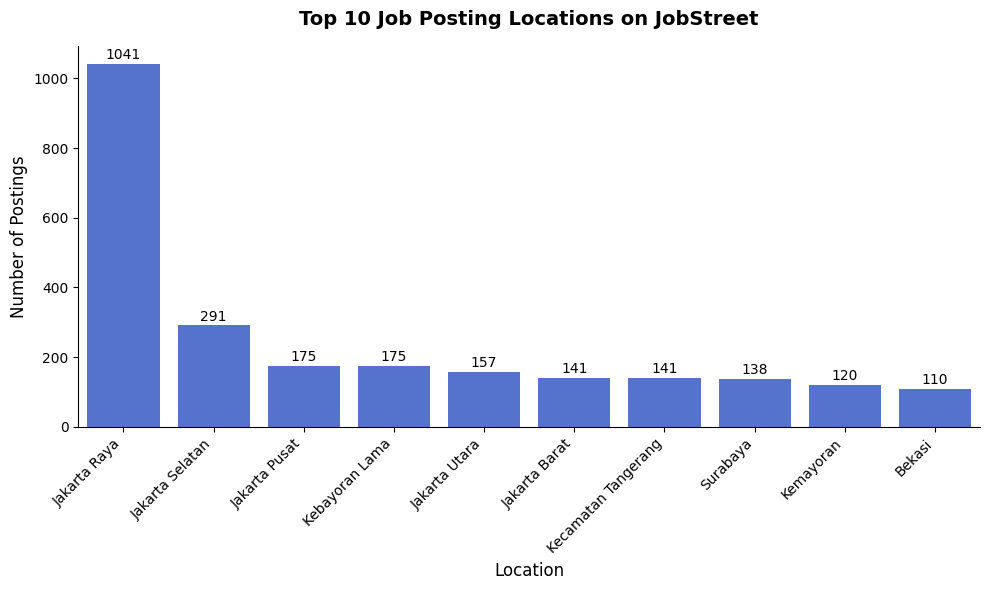

In [ ]:
df_top10_location = df["Location"].value_counts().head(10)
# df_top10_location
plt.figure(figsize=(10,6))
sns.barplot(
    x=df_top10_location.index,
    y=df_top10_location.values,
    color="royalblue"  # one consistent color
)

# Add labels on top of bars
for i, val in enumerate(df_top10_location.values):
    plt.text(i, val + 5, str(val), ha='center', va='bottom', fontsize=10)

plt.xlabel("Location", fontsize=12)
plt.ylabel("Number of Postings", fontsize=12)
plt.title("Top 10 Job Posting Locations on JobStreet", fontsize=14, fontweight="bold", pad=15)
plt.xticks(rotation=45, ha="right")
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
df = df[df['Unit']=='month']

In [ ]:
max_salary = df['Salary_High'].max()
min_salary = df['Salary_Low'].min()

print(f"Maximum Salary: {max_salary}")
print(f"Minimum Salary: {min_salary}")

Maximum Salary: 130000000.0
Minimum Salary: 2500.0


In [ ]:
df_max = df[df['Salary_High'] == max_salary]
df_max

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency
802,Vice President of Corporate Relations,(CEO & Manajemen Umum),PT Humana International Indonesia,Jakarta Raya,6 hari yang lalu,Rp 100.000.000 – Rp 130.000.000 per month,Develop and execute strategies to build and st...,100000000.0,130000000.0,month,IDR


<Axes: xlabel='Salary_Low', ylabel='Count'>

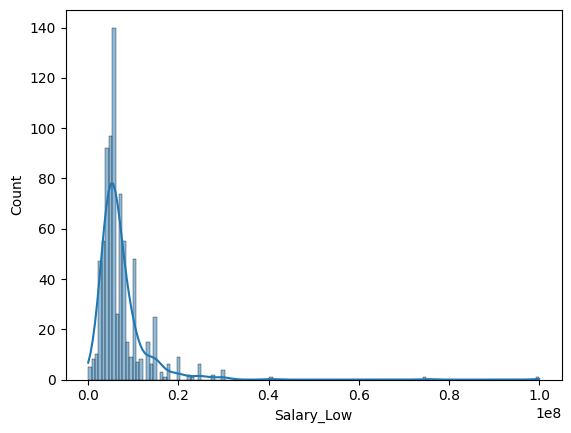

In [ ]:
sns.histplot(df['Salary_Low'], kde=True)

In [ ]:
q = df['Salary_Low'].quantile(0.01)
df_min = df[df['Salary_Low'] >= q]
min_salary = df_min['Salary_Low'].min()
min_salary

1500000.0

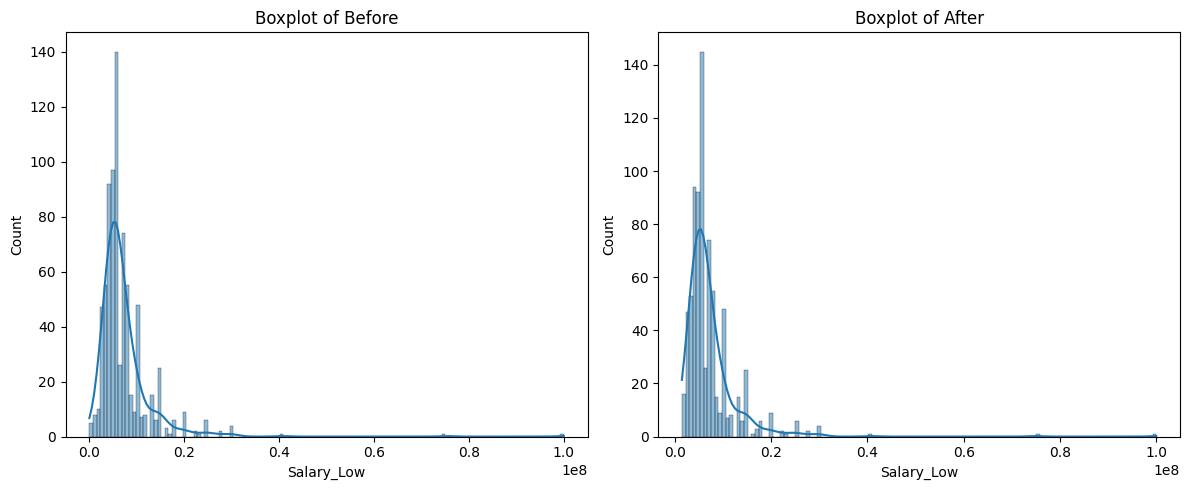

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=df, x='Salary_Low', ax=ax[0], kde=True)
ax[0].set_title('Boxplot of Before')

sns.histplot(data=df_min, x='Salary_Low', ax=ax[1], kde=True)
ax[1].set_title('Boxplot of After')

plt.tight_layout()
plt.show()


In [ ]:
df_min = df[df['Salary_Low'] == min_salary]
df_min

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency
952,Writer,"(Periklanan, Seni & Media)",PT Aldmic Indonesia,Jakarta Barat,19 jam yang lalu,Rp 1.500.000 – Rp 1.760.000 per month,team work,1500000.0,1760000.0,month,IDR
1324,Graphic Designer Intern,(Desain & Arsitektur),Hey Coco! Creative Agency,Jakarta Barat,14 hari yang lalu,Rp 1.500.000 – Rp 2.000.000 per month,We are Hey Coco! Creative Agency based on West...,1500000.0,2000000.0,month,IDR
1736,Legal Internship,(Hukum),PT Exabytes Network Indonesia,Jakarta Selatan,29 hari yang lalu,Rp 1.500.000 per month,"As a Legal Intern, you will be an integral par...",1500000.0,1500000.0,month,IDR
4061,Writer,"(Periklanan, Seni & Media)",PT Aldmic Indonesia,Jakarta Barat,20 jam yang lalu,Rp 1.500.000 – Rp 1.760.000 per month,team work,1500000.0,1760000.0,month,IDR
11553,Costumer Services Onine,(Call Center & Layanan Konsumen),Pondok Digital,Kubu Raya,19 jam yang lalu,Rp 1.500.000 – Rp 2.200.000 per month,Bekerja sambil beramal dan berdakwah,1500000.0,2200000.0,month,IDR
11633,SOZO - APOTEKER PENANGGUNG JAWAB (MANADO) - NO...,(Kesehatan & Medis),SEVEN Retail Group,Manado,24 hari yang lalu,Rp 1.500.000 – Rp 2.000.000 per month,"Tidak bekerja di klinik secara langsung, hanya...",1500000.0,2000000.0,month,IDR


In [ ]:
df['Average_salary'] = (df['Salary_High'] + df['Salary_Low']) / 2

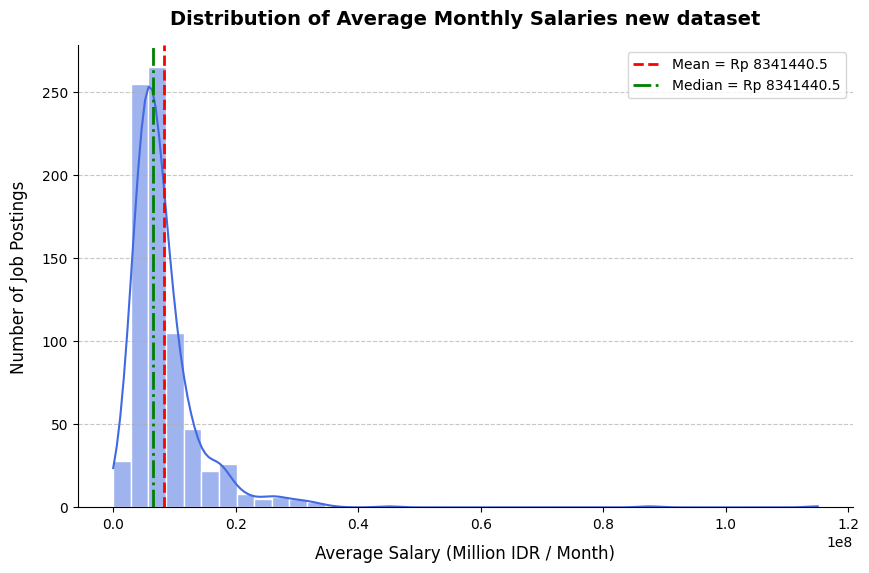

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df['Average_salary'], bins=40, kde=True, color="royalblue", edgecolor="white")
plt.xlabel("Average Salary (Million IDR / Month)", fontsize=12, labelpad=10)
plt.ylabel("Number of Job Postings", fontsize=12, labelpad=10)
plt.title("Distribution of Average Monthly Salaries new dataset", fontsize=14, fontweight="bold", pad=15)
plt.axvline(df['Average_salary'].mean(), color="red", linestyle="--", linewidth=2, label=f"Mean = Rp {df['Average_salary'].mean():.1f}")
plt.axvline(df['Average_salary'].median(), color="green", linestyle="-.", linewidth=2, label=f"Median = Rp {df['Average_salary'].mean():.1f}")

plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
sns.despine()
plt.show()

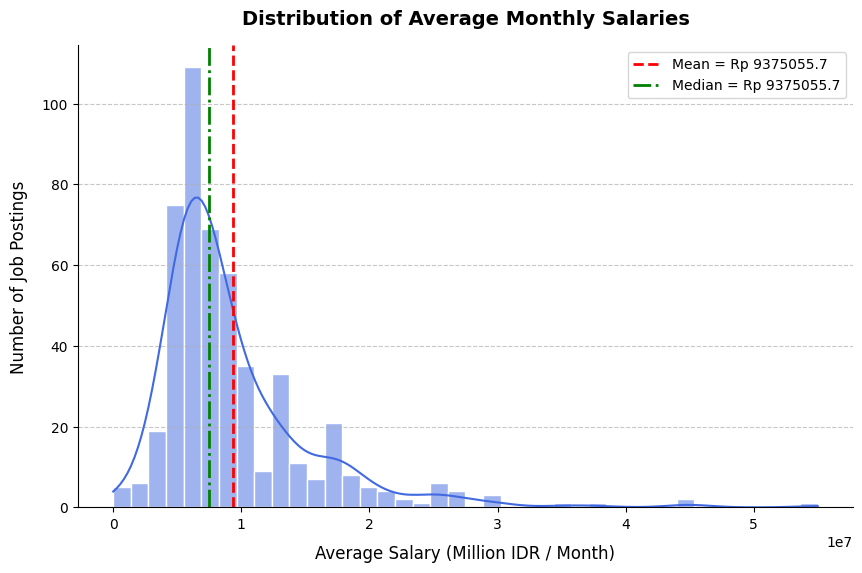

***Insight***

From the two images, we can observe several differences after generating the new dataset for visualization. I would like to highlight a few key points:



1.  **Longer tail in the new dataset:** The first image shows a longer tail compared to the old dataset, extending up to a maximum salary value of around 130 million rupiah, while the previous version only reached about 65 million rupiah.

2. **Shift in mean and median:** Another noticeable change is the shift in the mean and median values between the two graphs. The average salary decreased from approximately 9 million rupiah to 8 million rupiah. This shift occurred because Indonesia applies different minimum wage standards across cities. When these segmented data are compiled together, the mean and median values move leftward. For instance, Jakarta has a monthly minimum wage of Rp 5,396,761, whereas Medan’s is Rp 4,014,072.

## Step 3: Machine Learning Implementation on Predicting Job Salary

At this stage, I want to explore whether it is possible to predict salary levels based on the available features in the dataset. The dataset contains several job-related attributes, including title, classification, company, and location, which may provide valuable signals for building a predictive model.

**Features**: Title, Classification, Company, Location

**Target**: Average Salary, converted into discrete levels for classification


In [ ]:
df.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency,Average_salary
1,Young Professionals Fast Track,"(Manufaktur, Transportasi & Logistik)",Deliveree (PT Angkut Teknologi Indonesia),Jakarta Selatan,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ...",6000000.0,9000000.0,month,IDR,7500000.0
2,Customer Service and Operation Specialist (Air...,"(Manufaktur, Transportasi & Logistik)",Easy Speed International Logistics Limited,Jakarta Selatan,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...,8000000.0,12000000.0,month,IDR,10000000.0
5,Sales Admin,(Administrasi & Dukungan Perkantoran),PT AAF International Indonesia,Jakarta Utara,10 hari yang lalu,"Rp 5,000,000 – Rp 7,000,000 per month",Sales Admin plays a crucial role in supporting...,5000000.0,7000000.0,month,IDR,6000000.0
6,Senior Videographer (Singapore),"(Periklanan, Seni & Media)",Boom Digital Media,Jakarta Raya,14 hari yang lalu,"$5,000 – $7,500 per month (SGD)",This job will be based in Singapore. The work ...,5000.0,7500.0,month,USD,6250.0
8,Customer Service - Assistant Manager,(Call Center & Layanan Konsumen),redBus,Jakarta Raya,1 hari yang lalu,"Rp 11,000,000 – Rp 14,000,000 per month",Hiring for CS Asst. Manager to lead vendor-man...,11000000.0,14000000.0,month,IDR,12500000.0


In [ ]:
df.shape

(779, 12)

In [ ]:
df['Classification'] = df['Classification'].str.replace(r"\((.*)\)", r" \1", regex=True)

In [ ]:
df.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency,Average_salary
1,Young Professionals Fast Track,"Manufaktur, Transportasi & Logistik",Deliveree (PT Angkut Teknologi Indonesia),Jakarta Selatan,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ...",6000000.0,9000000.0,month,IDR,7500000.0
2,Customer Service and Operation Specialist (Air...,"Manufaktur, Transportasi & Logistik",Easy Speed International Logistics Limited,Jakarta Selatan,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...,8000000.0,12000000.0,month,IDR,10000000.0
5,Sales Admin,Administrasi & Dukungan Perkantoran,PT AAF International Indonesia,Jakarta Utara,10 hari yang lalu,"Rp 5,000,000 – Rp 7,000,000 per month",Sales Admin plays a crucial role in supporting...,5000000.0,7000000.0,month,IDR,6000000.0
6,Senior Videographer (Singapore),"Periklanan, Seni & Media",Boom Digital Media,Jakarta Raya,14 hari yang lalu,"$5,000 – $7,500 per month (SGD)",This job will be based in Singapore. The work ...,5000.0,7500.0,month,USD,6250.0
8,Customer Service - Assistant Manager,Call Center & Layanan Konsumen,redBus,Jakarta Raya,1 hari yang lalu,"Rp 11,000,000 – Rp 14,000,000 per month",Hiring for CS Asst. Manager to lead vendor-man...,11000000.0,14000000.0,month,IDR,12500000.0


I noticed that the dataset contains many variations of city names, such as Jakarta Utara, Jakarta Selatan, and so on, which actually all refer to the same location (Jakarta). To improve the quality of the data and avoid treating these as separate categories, it would be better to merge related city names into a single standardized form. For example, all Jakarta variants can be grouped into "Jakarta". The same approach should be applied to other cities as well.

In [ ]:
string_cities = df['Location'].value_counts().to_string()
print(string_cities)

Location
Jakarta Raya           87
Jakarta Selatan        81
Jakarta Utara          56
Jakarta Pusat          48
Bali                   42
Jakarta Barat          39
Badung                 29
Manado                 25
Surabaya               21
Tangerang              17
Semarang               17
Bandung                15
Jakarta Timur          12
Karawang               12
Denpasar               12
Cikarang Pusat         11
Tangerang Selatan      11
Batam                  11
Makassar               10
Palembang              10
Pekanbaru              10
Cikarang Selatan       10
Cikarang                9
Pontianak               9
Bekasi                  8
Medan                   7
Kalimantan Barat        6
Kuta Utara              6
Sidoarjo                6
Jawa Timur              5
Ubud                    5
Denpasar Barat          5
Malang                  5
Padang                  5
Kabupaten Tangerang     5
Banjarmasin             4
Kabupaten Bekasi        4
Banten                  4
Kut

In [ ]:
df.loc[df['Location'].str.contains("Jakarta", case=False), 'Location'] = "Jakarta"
df.loc[df['Location'].str.contains("Bekasi", case=False), 'Location'] = "Bekasi"
df.loc[df['Location'].str.contains("Cikarang", case=False), 'Location'] = "Cikarang"
df.loc[df['Location'].str.contains("Bandung", case=False), 'Location'] = "Bandung"
df.loc[df['Location'].str.contains("Bogor", case=False), 'Location'] = "Bogor"
df.loc[df['Location'].str.contains("Depok", case=False), 'Location'] = "Depok"
df.loc[df['Location'].str.contains("Badung", case=False), 'Location'] = "Bandung"
df.loc[df['Location'].str.contains("Tangerang", case=False), 'Location'] = "Tangerang"

In [ ]:
string_cities = df['Location'].value_counts().to_string()
top20_cities = df['Location'].value_counts().nlargest(20).index.tolist()
print(top20_cities)

['Jakarta', 'Bandung', 'Bali', 'Tangerang', 'Cikarang', 'Manado', 'Surabaya', 'Semarang', 'Bekasi', 'Karawang', 'Denpasar', 'Batam', 'Pekanbaru', 'Makassar', 'Palembang', 'Pontianak', 'Medan', 'Kuta Utara', 'Kalimantan Barat', 'Sidoarjo']


In [ ]:
df = df[df['Location'].isin(top20_cities)]
df.shape

(651, 12)

In [ ]:
df['Classification'].value_counts()

,count
Classification,
Penjualan,138
"Manufaktur, Transportasi & Logistik",86
Pemasaran & Komunikasi,53
Administrasi & Dukungan Perkantoran,48
Ritel & Produk Konsumen,45
Hospitaliti & Pariwisata,40
Teknologi Informasi & Komunikasi,34
Akuntansi,30
Teknik,27


Here, I checked how many job titles exist within each classification, and it turns out there are too many to handle efficiently with one-hot encoding. Additionally, categorizing each job title manually for every classification would be very time-consuming. In this case, scikit-learn provides a library for extracting features from text and converting them into vector values using **sklearn.feature_extraction.text**, which can split the text into multiple tokens automatically.

In [ ]:
df['Classification'] = df['Classification'].str.strip()
df_review = df[df['Classification']=='Administrasi & Dukungan Perkantoran']
for i in df_review['Title'].unique():
  print(i)

Sales Admin
Visa & Document Staff
Outbound Document Staff
PERSONAL ASSISTANT CEO
Logistic and/or Sales Admin Staff
Marketing Support - Jakarta - WFO (ID: 683261)
Administrative Executive (MANDARIN SPEAKER)
Korean Translator
In-house Translators (Penerjemahan Internal)
Personal Assistant to General Manager
Sales & Interpreter Staff (Mandarin Speaker) - Real Estate (A-122675)
Japanese Interpreter - Finance (A-122690)
Translator Mandarin
MANDARIN ASSISTANT & TRANSLATOR
Sales Administration (Staff)
Executive Assistant
Receptionist (Mandarin speaker)
Personal Assistant
Formalities Officer (Customer Service)
Visa Officer
Business Assistant
ADMIN SALES
SALES ADMIN
Corporate Secretary
Young Professionals - Work From Home (WFH)
Business Planning Administration
Administration (Bandung)
Japanese Interpreter - Manufacturing (A-122334)
PROJECT SECRETARY
Client Work Visa Processing Officer
SECRETARY
Sales Administration / Customer Service - Trading - Bekasi (C-122822)
Marketing Administrator (Import

In [ ]:
df.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency,Average_salary
1,Young Professionals Fast Track,"Manufaktur, Transportasi & Logistik",Deliveree (PT Angkut Teknologi Indonesia),Jakarta,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ...",6000000.0,9000000.0,month,IDR,7500000.0
2,Customer Service and Operation Specialist (Air...,"Manufaktur, Transportasi & Logistik",Easy Speed International Logistics Limited,Jakarta,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...,8000000.0,12000000.0,month,IDR,10000000.0
5,Sales Admin,Administrasi & Dukungan Perkantoran,PT AAF International Indonesia,Jakarta,10 hari yang lalu,"Rp 5,000,000 – Rp 7,000,000 per month",Sales Admin plays a crucial role in supporting...,5000000.0,7000000.0,month,IDR,6000000.0
6,Senior Videographer (Singapore),"Periklanan, Seni & Media",Boom Digital Media,Jakarta,14 hari yang lalu,"$5,000 – $7,500 per month (SGD)",This job will be based in Singapore. The work ...,5000.0,7500.0,month,USD,6250.0
8,Customer Service - Assistant Manager,Call Center & Layanan Konsumen,redBus,Jakarta,1 hari yang lalu,"Rp 11,000,000 – Rp 14,000,000 per month",Hiring for CS Asst. Manager to lead vendor-man...,11000000.0,14000000.0,month,IDR,12500000.0


### Focusing Data to IDR only

/tmp/ipython-input-3419061017.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Average_salary'], kde=True)


<Axes: xlabel='Average_salary', ylabel='Density'>

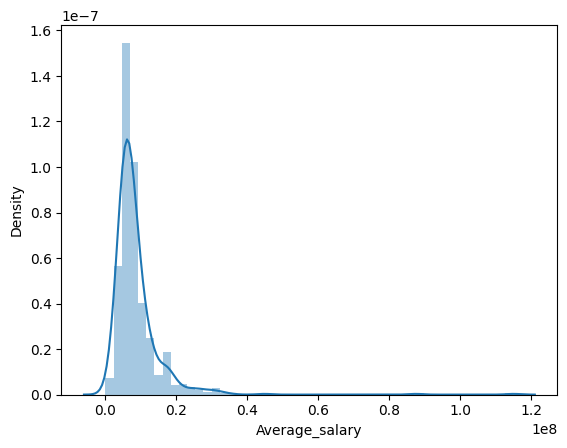

In [ ]:
df = df[df['Currency']=='IDR']

sns.distplot(df['Average_salary'], kde=True)

/tmp/ipython-input-655939146.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Average_salary'], kde=True)


<Axes: xlabel='Average_salary', ylabel='Density'>

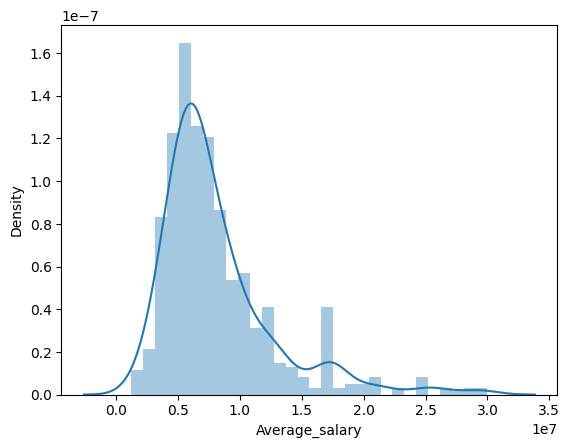

In [ ]:
#Remove outlier value and take 99% data
q = df['Average_salary'].quantile(0.99)
df = df[df['Average_salary'] < q]

df = df[df['Average_salary'] > 100000]
sns.distplot(df['Average_salary'], kde=True)

In [ ]:
df.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency,Average_salary
1,Young Professionals Fast Track,"Manufaktur, Transportasi & Logistik",Deliveree (PT Angkut Teknologi Indonesia),Jakarta,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ...",6000000.0,9000000.0,month,IDR,7500000.0
2,Customer Service and Operation Specialist (Air...,"Manufaktur, Transportasi & Logistik",Easy Speed International Logistics Limited,Jakarta,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...,8000000.0,12000000.0,month,IDR,10000000.0
5,Sales Admin,Administrasi & Dukungan Perkantoran,PT AAF International Indonesia,Jakarta,10 hari yang lalu,"Rp 5,000,000 – Rp 7,000,000 per month",Sales Admin plays a crucial role in supporting...,5000000.0,7000000.0,month,IDR,6000000.0
8,Customer Service - Assistant Manager,Call Center & Layanan Konsumen,redBus,Jakarta,1 hari yang lalu,"Rp 11,000,000 – Rp 14,000,000 per month",Hiring for CS Asst. Manager to lead vendor-man...,11000000.0,14000000.0,month,IDR,12500000.0
10,Visa & Document Staff,Administrasi & Dukungan Perkantoran,PT Traxist Kreatif Indonesia,Jakarta,19 jam yang lalu,Rp 5.000.000 – Rp 6.500.000 per month,"Competitive monthly salary, supportive and col...",5000000.0,6500000.0,month,IDR,5750000.0


In [ ]:
#leveling salary into 4 levels for categorical classification
bins = [0, 5_000_000, 10_000_000, 20_000_000, 40_000_000]
labels = ["level_1", "level_2", "level_3", "level_4"]

df["Salary_level"] = pd.cut(df["Average_salary"], bins=bins, labels=labels)
df.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency,Average_salary,Salary_level,Combined_text,salary_encoded
1,Young Professionals Fast Track,"Manufaktur, Transportasi & Logistik",Deliveree (PT Angkut Teknologi Indonesia),Jakarta,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ...",6000000.0,9000000.0,month,IDR,7500000.0,level_2,"Young Professionals Fast Track Manufaktur, Tra...",1
2,Customer Service and Operation Specialist (Air...,"Manufaktur, Transportasi & Logistik",Easy Speed International Logistics Limited,Jakarta,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...,8000000.0,12000000.0,month,IDR,10000000.0,level_2,Customer Service and Operation Specialist (Air...,1
5,Sales Admin,Administrasi & Dukungan Perkantoran,PT AAF International Indonesia,Jakarta,10 hari yang lalu,"Rp 5,000,000 – Rp 7,000,000 per month",Sales Admin plays a crucial role in supporting...,5000000.0,7000000.0,month,IDR,6000000.0,level_2,Sales Admin Administrasi & Dukungan Perkantora...,1
8,Customer Service - Assistant Manager,Call Center & Layanan Konsumen,redBus,Jakarta,1 hari yang lalu,"Rp 11,000,000 – Rp 14,000,000 per month",Hiring for CS Asst. Manager to lead vendor-man...,11000000.0,14000000.0,month,IDR,12500000.0,level_3,Customer Service - Assistant Manager Call Cent...,2
10,Visa & Document Staff,Administrasi & Dukungan Perkantoran,PT Traxist Kreatif Indonesia,Jakarta,19 jam yang lalu,Rp 5.000.000 – Rp 6.500.000 per month,"Competitive monthly salary, supportive and col...",5000000.0,6500000.0,month,IDR,5750000.0,level_2,Visa & Document Staff Administrasi & Dukungan ...,1


In [ ]:
#Unbalanced Data dispersion case
df['Salary_level'].value_counts()

,count
Salary_level,
level_2,359
level_1,146
level_3,115
level_4,19


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 639 entries, 1 to 11693
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Title           639 non-null    object  
 1   Classification  639 non-null    object  
 2   Company         604 non-null    object  
 3   Location        639 non-null    object  
 4   Posting         639 non-null    object  
 5   Salary          639 non-null    object  
 6   Description     639 non-null    object  
 7   Salary_Low      639 non-null    float64 
 8   Salary_High     639 non-null    float64 
 9   Unit            639 non-null    object  
 10  Currency        639 non-null    object  
 11  Average_salary  639 non-null    float64 
 12  Salary_level    639 non-null    category
 13  Combined_text   639 non-null    object  
 14  salary_encoded  639 non-null    int64   
dtypes: category(1), float64(3), int64(1), object(10)
memory usage: 75.7+ KB


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer # Extract words features
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# 1. Preparation data feature

#1.1 Combined text feature
df["Combined_text"] = (
    df["Title"].fillna('') + " " +
    df["Classification"].fillna('') + " " +
    df["Company"].fillna('') + " " +
    df["Location"].fillna('')
)

X = df["Combined_text"]

#1.2 Apply one-hot encoder to label data salary
le = LabelEncoder()
df["salary_encoded"] = le.fit_transform(df["Salary_level"])
y = df["salary_encoded"]

# print("Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

In [ ]:

#1.3 Split data training and testing data to prevent overfitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#2. Training Model

#2.1 Create pipeline and set hyperparameters
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1,2))),
    # ("lr", LogisticRegression(max_iter=1000,class_weight="balanced", random_state=42, n_jobs=-1))
    # ("rf", RandomForestClassifier(n_estimators=300, max_depth=None,class_weight="balanced",random_state=42,n_jobs=-1))
    # ("svm", LinearSVC(class_weight="balanced", random_state=42))
    # ("xgb", XGBClassifier(objective="multi:softmax", num_class=4, n_estimators=300, class_weight="balanced", random_state=42,n_jobs=-1))
    ("lgbm", LGBMClassifier(objective="multiclass", num_class=4, n_estimators=300, class_weight="balanced", random_state=42, n_jobs=-1))
])

pipeline.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1210
[LightGBM] [Info] Number of data points in the train set: 511, number of used features: 71
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
                ('lgbm',
                 LGBMClassifier(class_weight='balanced', n_estimators=300,
                                n_jobs=-1, num_class=4, objective='multiclass',
                                random_state=42))])

Accuracy: 0.4296875
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.39      0.47        28
           1       0.50      0.57      0.53        67
           2       0.19      0.22      0.20        27
           3       0.00      0.00      0.00         6

    accuracy                           0.43       128
   macro avg       0.32      0.30      0.30       128
weighted avg       0.43      0.43      0.42       128



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


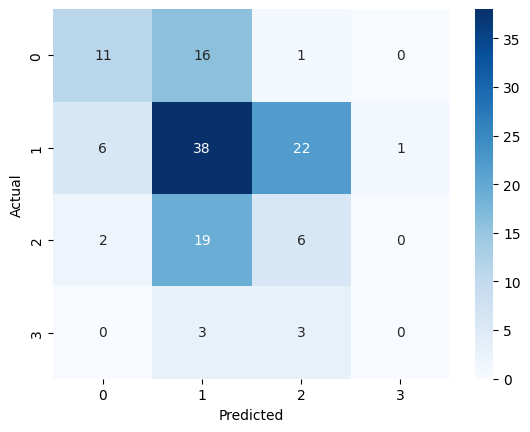

   Actual  Predicted
0       1          2
1       3          2
2       0          0
3       0          0
4       0          0
5       0          1
6       1          1
7       1          1
8       1          1
9       0          1


In [ ]:

#3. Evaluation

#3.1 create predicion value
y_pred = pipeline.predict(X_test)

#3.2 Check Accuracy and Classification Report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

#3.3 Generete Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#3.4 Create data frame result
results_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred
})

print(results_df.head(10))

###Insight and Evaluation

1. Overall Performance

- **Accuracy:** 0.57 → the model correctly predicts 57% of the samples.

- **Weighted avg F1-score**: 0.56 → balanced measure of precision and recall across all classes.

not really bad for the first classification model and this model are going to be improve in the project

2. Class-wise Performance

- **Class 1**  the best-predicted class, with an F1 score of 0.66, showing that the model performs well when the true label is 1.

- **Classes 2 and 3** perform poorly, with recall as low as 0.33, indicating the model misses many samples. Class 3 is particularly challenging, with only 19 samples, making it difficult for the model to learn meaningful patterns.

- **Class 0** shows moderate performance, with an F1 score around 0.52, slightly better than classes 2 and 3. As the figure shows, the model predicts level 1 and level 2 salaries in a roughly balanced way. One key factor is that most jobs have salaries between 5–10 million IDR, with a mean around 8 million IDR, which makes it difficult for the model to distinguish between these levels.

3. Improvement for Next project


-Experiment with non-linear models such as SVM, Random Forest Regression, and Boosting methods.

-Apply resampling techniques to handle class imbalance, e.g., SMOTE or undersampling of the majority class.

-Implement cross-validation combined with GridSearch for hyperparameter tuning.

-Develop and test a neural network model for classification tasks.

-Explore NLP approaches, including transformer-based models with Hugging Face.

### Implement SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.decomposition import TruncatedSVD

pipeline_smote = ImbPipeline([
    ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1,2))),
    ("svd", TruncatedSVD(n_components=200, random_state=42)),   # reduce sparsity
    ("smote", SMOTE(random_state=42, sampling_strategy="auto", k_neighbors=3)),
    # ("lr", LogisticRegression(max_iter=1000,class_weight="balanced", random_state=42, n_jobs=-1))
    # ("rf", RandomForestClassifier(n_estimators=300, max_depth=None,class_weight="balanced",random_state=42,n_jobs=-1))
    # ("svm", LinearSVC(class_weight="balanced", random_state=42))
    # ("xgb", XGBClassifier(objective="multi:softmax", num_class=4, n_estimators=300,max_depth=-1, learning_rate=0.1, class_weight="balanced", random_state=42, n_jobs=-1))
    ("lgbm", LGBMClassifier(objective="multiclass", num_class=4, n_estimators=300, max_depth=-1, learning_rate=0.1, class_weight="balanced", random_state=42, n_jobs=-1))
])

In [ ]:
pipeline_smote.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 200
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
                ('svd', TruncatedSVD(n_components=200, random_state=42)),
                ('smote', SMOTE(k_neighbors=3, random_state=42)),
                ('lgbm',
                 LGBMClassifier(class_weight='balanced', n_estimators=300,
                                n_jobs=-1, num_class=4, objective='multiclass',
                                random_state=42))])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.5546875
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.57      0.54        28
           1       0.62      0.69      0.65        67
           2       0.40      0.30      0.34        27
           3       0.33      0.17      0.22         6

    accuracy                           0.55       128
   macro avg       0.47      0.43      0.44       128
weighted avg       0.54      0.55      0.54       128



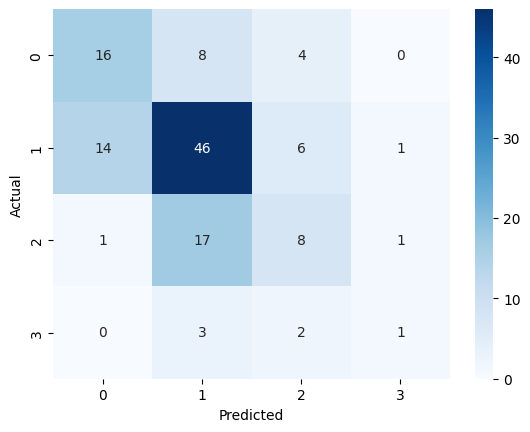

   Actual  Predicted
0       1          1
1       3          2
2       0          0
3       0          1
4       0          0
5       0          0
6       1          1
7       1          0
8       1          1
9       0          1


In [ ]:

#3. Evaluation

#3.1 create predicion value
y_pred = pipeline_smote.predict(X_test)

#3.2 Check Accuracy and Classification Report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

#3.3 Generete Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#3.4 Create data frame result
results_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred
})

print(results_df.head(10))

### Cross Validation


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, X, y, cv=skf, scoring=make_scorer(f1_score, average="macro"))

print("Cross-validation macro F1 scores:", scores)
print("Mean macro F1:", np.mean(scores))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 476, number of used features: 54
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1078
[LightGBM] [Info] Number of data points in the train set: 477, number of used features: 60
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1083
[LightGBM] [Info] Number of data points in the train set: 477, number of used features: 63
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 477, number of used features: 57
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 981
[LightGBM] [Info] Number of data points in the train set: 477, number of used features: 51
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
param_grid = {
    "lgbm__num_leaves": [31, 63],          # tree complexity
    "lgbm__learning_rate": [0.05, 0.1],    # step size
    "lgbm__n_estimators": [300, 500],      # number of trees
    "lgbm__max_depth": [-1, 15]            # unlimited vs. medium depth
}


In [ ]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1_macro",      # focus on balanced performance
    cv=3,                    # 3-fold cross-validation
    n_jobs=-1,               # parallel processing
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1210
[LightGBM] [Info] Number of data points in the train set: 511, number of used features: 71
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=10000,
                                                        ngram_range=(1, 2))),
                                       ('lgbm',
                                        LGBMClassifier(class_weight='balanced',
                                                       n_estimators=300,
                                                       n_jobs=-1, num_class=4,
                                                       objective='multiclass',
                                                       random_state=42))]),
             n_jobs=-1,
             param_grid={'lgbm__learning_rate': [0.05, 0.1],
                         'lgbm__max_depth': [-1, 15],
                         'lgbm__n_estimators': [300, 500],
                         'lgbm__num_leaves': [31, 63]},
             scoring='f1_macro', verbose=2)

In [ ]:
print("Best Params:", grid_search.best_params_)
print("Best CV Macro F1:", grid_search.best_score_)

Best Params: {'lgbm__learning_rate': 0.05, 'lgbm__max_depth': 15, 'lgbm__n_estimators': 300, 'lgbm__num_leaves': 31}
Best CV Macro F1: 0.4073162162997075


In [ ]:
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score, f1_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("Weighted F1:", f1_score(y_test, y_pred, average="weighted"))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.4609375
Macro F1: 0.37054369097251766
Weighted F1: 0.4551615478494852

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.39      0.48        28
           1       0.53      0.63      0.58        67
           2       0.17      0.19      0.18        27
           3       0.50      0.17      0.25         6

    accuracy                           0.46       128
   macro avg       0.45      0.34      0.37       128
weighted avg       0.47      0.46      0.46       128



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
